In [1]:
!pip install skopt
!pip install scikit-optimize

ERROR: Could not find a version that satisfies the requirement skopt (from versions: none)
ERROR: No matching distribution found for skopt
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00


In [2]:
!pip install xgboost lightgbm catboost matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:36:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.97      0.91      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115

ROC AUC: 0.9844998402045382
Accuracy: 0.9847533632286996


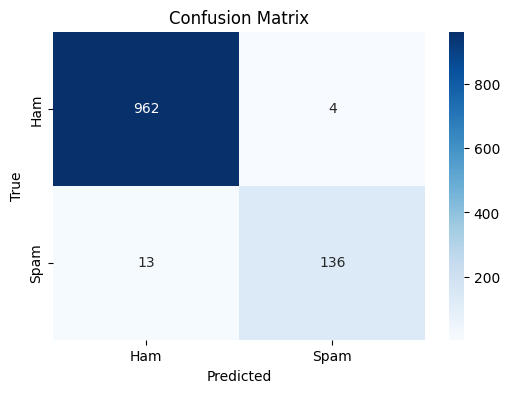

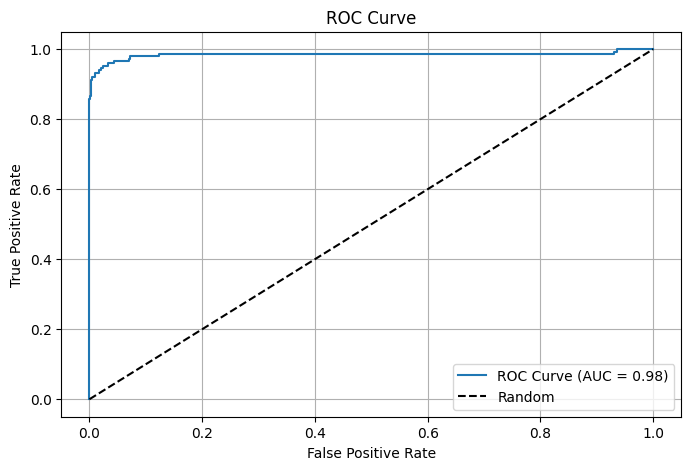

<Figure size 1000x600 with 0 Axes>

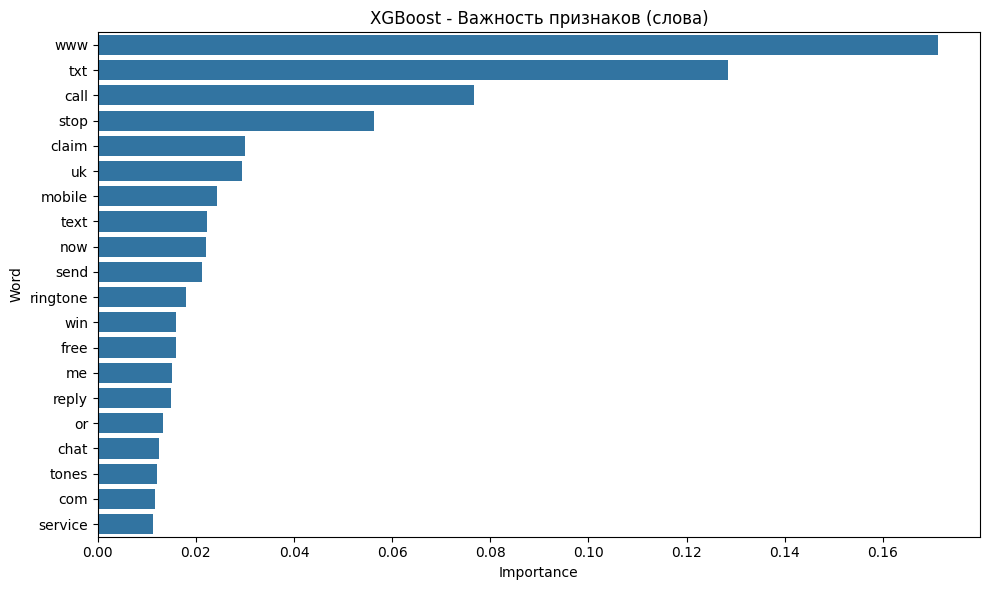


=== Сравнение моделей по Accuracy ===


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:36:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost: 0.9848
[LightGBM] [Info] Number of positive: 598, number of negative: 3859
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13310
[LightGBM] [Info] Number of data points in the train set: 4457, number of used features: 471
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.134171 -> initscore=-1.864573
[LightGBM] [Info] Start training from score -1.864573


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM: 0.9857
CatBoost: 0.9812
Dummy: 0.8664


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import io
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, accuracy_score
)

from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

# === 1. Загрузка и подготовка данных ===
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
response = urllib.request.urlopen(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.read()))

with zip_file.open('SMSSpamCollection') as file:
    df = pd.read_csv(file, sep='\t', header=None, names=['label', 'message'])

df['label'] = df['label'].map({'ham': 0, 'spam': 1})

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['message'])
y = df['label'].values

# === 2. Делим на обучающую и тестовую выборки ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === 3. Обучение классификатора XGBoost ===
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train, y_train)

# === 4. Оценка ===
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))

# === 5. Матрица ошибок ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# === 6. ROC-кривая ===
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# === 7. Важность признаков (слов) ===
plt.figure(figsize=(10, 6))
importances = xgb_clf.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Соединяем важности с названиями признаков (слов)
feat_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Сортируем по убыванию важности
top_features = feat_importance.sort_values(by='importance', ascending=False).head(20)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title("XGBoost - Важность признаков (слова)")
plt.xlabel("Importance")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


# === 8. Сравнение с другими моделями ===
models = {
    "XGBoost": xgb_clf,
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Dummy": DummyClassifier(strategy='most_frequent')
}

print("\n=== Сравнение моделей по Accuracy ===")
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"{name}: {acc:.4f}")


In [7]:
from sklearn.naive_bayes import MultinomialNB



=== Multinomial Naive Bayes - Classification Report ===
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.75      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115

ROC AUC: 0.9811441355065517
Accuracy: 0.9668161434977578


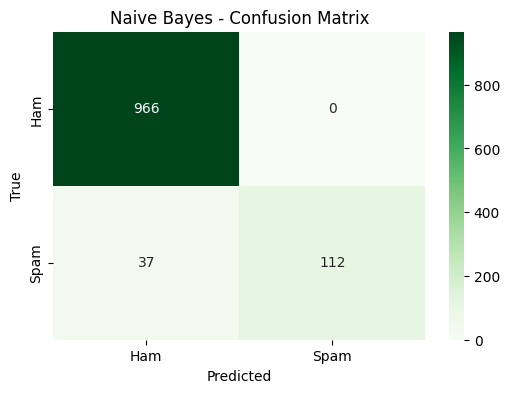

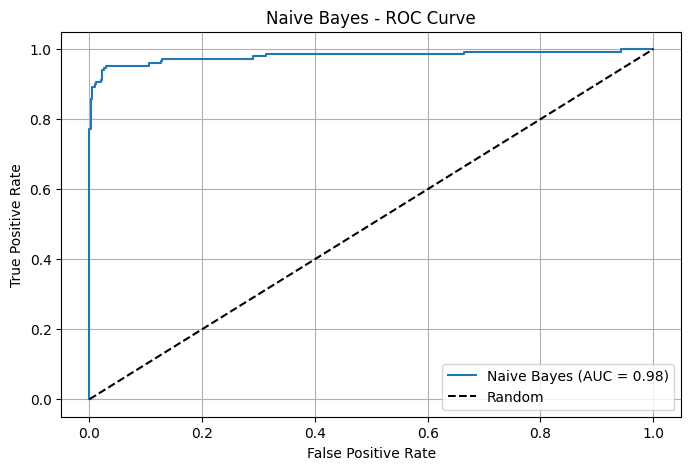

In [8]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

y_pred_nb = nb_clf.predict(X_test)
y_proba_nb = nb_clf.predict_proba(X_test)[:, 1]

print("\n=== Multinomial Naive Bayes - Classification Report ===")
print(classification_report(y_test, y_pred_nb))

print("ROC AUC:", roc_auc_score(y_test, y_proba_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

# --- Матрица ошибок ---
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Naive Bayes - Confusion Matrix')
plt.show()

# --- ROC-кривая ---
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
plt.figure(figsize=(8, 5))
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_score(y_test, y_proba_nb):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes - ROC Curve')
plt.legend()
plt.grid(True)
plt.show()
